# AirPassengers Forecasting with Foundation Models

This notebook demonstrates time-series forecasting using the FAIM platform with the classic AirPassengers dataset. We'll compare three state-of-the-art foundation models (FlowState, Chronos2, and TiRex) for both point and probabilistic forecasting.

The AirPassengers dataset contains monthly totals of international airline passengers from 1949 to 1960, showing clear seasonal patterns and an upward trend.

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Provide FAIM API Key
FAIM_API_KEY = os.environ.get("FAIM_API_KEY")

from faim_sdk import Chronos2ForecastRequest, FlowStateForecastRequest, ForecastClient, TiRexForecastRequest
from faim_sdk.eval import mae, mse

## Step 1: Load and Prepare the Data

We'll load the classic AirPassengers dataset from a CSV file, which contains monthly airline passenger counts from 1949 to 1960. We'll use the last 12 months (1 year) as our test set with a 12-month forecast horizon.

In [ ]:
# Load AirPassengers dataset
# Dataset: Monthly totals of international airline passengers (1949-1960)
# 144 observations with clear seasonal patterns and upward trend
df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/"
    "TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv",
    index_col=0,
    parse_dates=True,
)

# Extract the target variable
data = df["#Passengers"].values.astype(np.float32)

# Define forecast horizon (12 months)
horizon = 12

# Split into train and test
train_data = data[:-horizon]
test_data = data[-horizon:]

# Use only the last 2048 points for training (API constraint)
max_sequence_length = 2048
if len(train_data) > max_sequence_length:
    train_data = train_data[-max_sequence_length:]

# Reshape to 3D format (batch_size=1, sequence_length, features=1)
train_data_3d = train_data.reshape(1, -1, 1)
test_data_3d = test_data.reshape(1, -1, 1)

print(f"AirPassengers Dataset Summary")
print(f"=" * 60)
print(f"Total data points: {len(data)}")
print(f"Training data shape: {train_data_3d.shape} (last {len(train_data)} months)")
print(f"Test data shape (12-month horizon): {test_data_3d.shape}")
print(f"\nData summary:")
print(f"  Train - Min: {train_data.min():.0f}, Max: {train_data.max():.0f}, Mean: {train_data.mean():.0f} passengers")
print(f"  Test  - Min: {test_data.min():.0f}, Max: {test_data.max():.0f}, Mean: {test_data.mean():.0f} passengers")

## Step 2: Initialize the FAIM Client

We'll create a ForecastClient instance to access the three foundation models available through FAIM.

In [40]:
# Initialize the FAIM client
client = ForecastClient(api_key=FAIM_API_KEY)

print("FAIM Client initialized successfully")

FAIM Client initialized successfully


## Step 3: Point Forecasts (24-hour ahead)

We'll generate point forecasts from all three models: FlowState, Chronos2, and TiRex. Point forecasts provide a single predicted value for each time step, representing the expected value of the electricity price.

In [41]:
# Generate point forecasts from all models
print("Generating point forecasts from all models...")

# FlowState
flowstate_request = FlowStateForecastRequest(
    x=train_data_3d, 
    horizon=horizon, 
    output_type="point"
)
flowstate_response = client.forecast(flowstate_request)

# Chronos2
chronos2_request = Chronos2ForecastRequest(
    x=train_data_3d, 
    horizon=horizon, 
    output_type="point"
)
chronos2_response = client.forecast(chronos2_request)

# TiRex
tirex_request = TiRexForecastRequest(
    x=train_data_3d, 
    horizon=horizon, 
    output_type="point"
)
tirex_response = client.forecast(tirex_request)

print("✓ Point forecasts generated successfully\n")

# Store predictions
point_forecasts = {
    "FlowState": flowstate_response.point,
    "Chronos2": chronos2_response.point,
    "TiRex": tirex_response.point
}

Generating point forecasts from all models...
✓ Point forecasts generated successfully



### Evaluate Point Forecasts

We evaluate point forecasts using two standard metrics:
- **MAE (Mean Absolute Error)**: Average absolute difference between predicted and actual values. Measured in the same units as the data (number of passengers).
- **MSE (Mean Squared Error)**: Average squared difference. More sensitive to large errors than MAE.

In [42]:
# Evaluate point forecasts with metrics
print("Point Forecast Evaluation")
print("=" * 60)

metrics_data = []
for model_name, predictions in point_forecasts.items():
    mae_score = mae(test_data_3d, predictions)
    mse_score = mse(test_data_3d, predictions)
    metrics_data.append({
        "Model": model_name,
        "MAE": mae_score,
        "MSE": mse_score
    })
    print(f"{model_name:12s} | MAE: {mae_score:7.4f} | MSE: {mse_score:7.4f}")

print("=" * 60)

# Create metrics dataframe for later reference
metrics_df = pd.DataFrame(metrics_data)
print(f"\nBest MAE: {metrics_df.loc[metrics_df['MAE'].idxmin(), 'Model']} ({metrics_df['MAE'].min():.4f})")
print(f"Best MSE: {metrics_df.loc[metrics_df['MSE'].idxmin(), 'Model']} ({metrics_df['MSE'].min():.4f})")

Point Forecast Evaluation
FlowState    | MAE: 27.6654 | MSE: 967.7044
Chronos2     | MAE: 13.4456 | MSE: 384.7325
TiRex        | MAE: 10.4162 | MSE: 225.6283

Best MAE: TiRex (10.4162)
Best MSE: TiRex (225.6283)


### Visualize Point Forecasts

The plot below shows the training data context, the true 12-month test values, and predictions from all three models. This classic dataset clearly shows seasonal patterns and an upward trend that the models must capture.

In [ ]:
# Visualize point forecasts
fig, ax = plt.subplots(figsize=(14, 6))

# Get actual training data length after truncation
actual_train_size = train_data_3d.shape[1]

# Show last 24 months of training data for context
context_window = 24
train_context_start = max(0, actual_train_size - context_window)
train_context_indices = np.arange(train_context_start, actual_train_size)

ax.plot(
    train_context_indices, 
    train_data[train_context_start:], 
    label="Training Data (last 24 months)", 
    color="blue", 
    linewidth=2,
    alpha=0.8
)

# Plot test data (actual values)
test_indices = np.arange(actual_train_size, actual_train_size + horizon)
ax.plot(
    test_indices, 
    test_data, 
    label="Actual Test Values", 
    color="black", 
    linewidth=2.5, 
    linestyle="--",
    marker="o",
    markersize=6
)

# Plot model predictions
colors = {"FlowState": "#2ecc71", "Chronos2": "#e74c3c", "TiRex": "#f39c12"}
for model_name, pred in point_forecasts.items():
    ax.plot(
        test_indices, 
        pred[0, :, 0], 
        label=f"{model_name} Forecast", 
        color=colors[model_name], 
        linewidth=2, 
        alpha=0.8,
        marker="s",
        markersize=5
    )

# Add separator line
ax.axvline(x=actual_train_size, color="gray", linestyle=":", linewidth=1.5, alpha=0.7, label="Train/Test Split")

ax.set_xlabel("Months", fontsize=12)
ax.set_ylabel("Number of Passengers", fontsize=12)
ax.set_title("12-Month Ahead Point Forecasts - AirPassengers", fontsize=14, fontweight="bold")
ax.legend(loc="best", fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## Step 4: Probabilistic Forecasts (Quantiles)

In addition to point forecasts, we generate probabilistic forecasts that provide uncertainty estimates. Each model returns quantile predictions, which can be interpreted as confidence intervals:
- **FlowState & TiRex**: Return 9 default quantile levels (0.1, 0.2, ..., 0.9)
- **Chronos2**: Supports custom quantiles - we'll use the same 9-level grid for comparison

These quantile forecasts allow us to quantify uncertainty and assess prediction intervals, which is particularly important for seasonal datasets like AirPassengers.

In [44]:
# Generate quantile forecasts from all models
print("Generating quantile forecasts from all models...")

quantile_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# FlowState with default quantiles
flowstate_q_request = FlowStateForecastRequest(
    x=train_data_3d,
    horizon=horizon,
    prediction_type="quantile",
    output_type="quantiles"
)
flowstate_q_response = client.forecast(flowstate_q_request)

# Chronos2 with custom quantiles
chronos2_q_request = Chronos2ForecastRequest(
    x=train_data_3d,
    horizon=horizon,
    output_type="quantiles",
    quantiles=quantile_levels
)
chronos2_q_response = client.forecast(chronos2_q_request)

# TiRex with default quantiles
tirex_q_request = TiRexForecastRequest(
    x=train_data_3d,
    horizon=horizon,
    output_type="quantiles"
)
tirex_q_response = client.forecast(tirex_q_request)

print("✓ Quantile forecasts generated successfully\n")

# Store quantile predictions
quantile_forecasts = {
    "FlowState": flowstate_q_response.quantiles,
    "Chronos2": chronos2_q_response.quantiles,
    "TiRex": tirex_q_response.quantiles
}

Generating quantile forecasts from all models...
✓ Quantile forecasts generated successfully



### Visualize Probabilistic Forecasts

Each subplot shows one model's quantile predictions with prediction intervals:
- The colored band represents the 80% interval (10th to 90th percentile)
- The darker band represents the 50% interval (25th to 75th percentile)  
- The solid line shows the median forecast (50th percentile)
- The dashed black line shows the actual test values

The width of these intervals shows model uncertainty - wider bands indicate higher uncertainty.

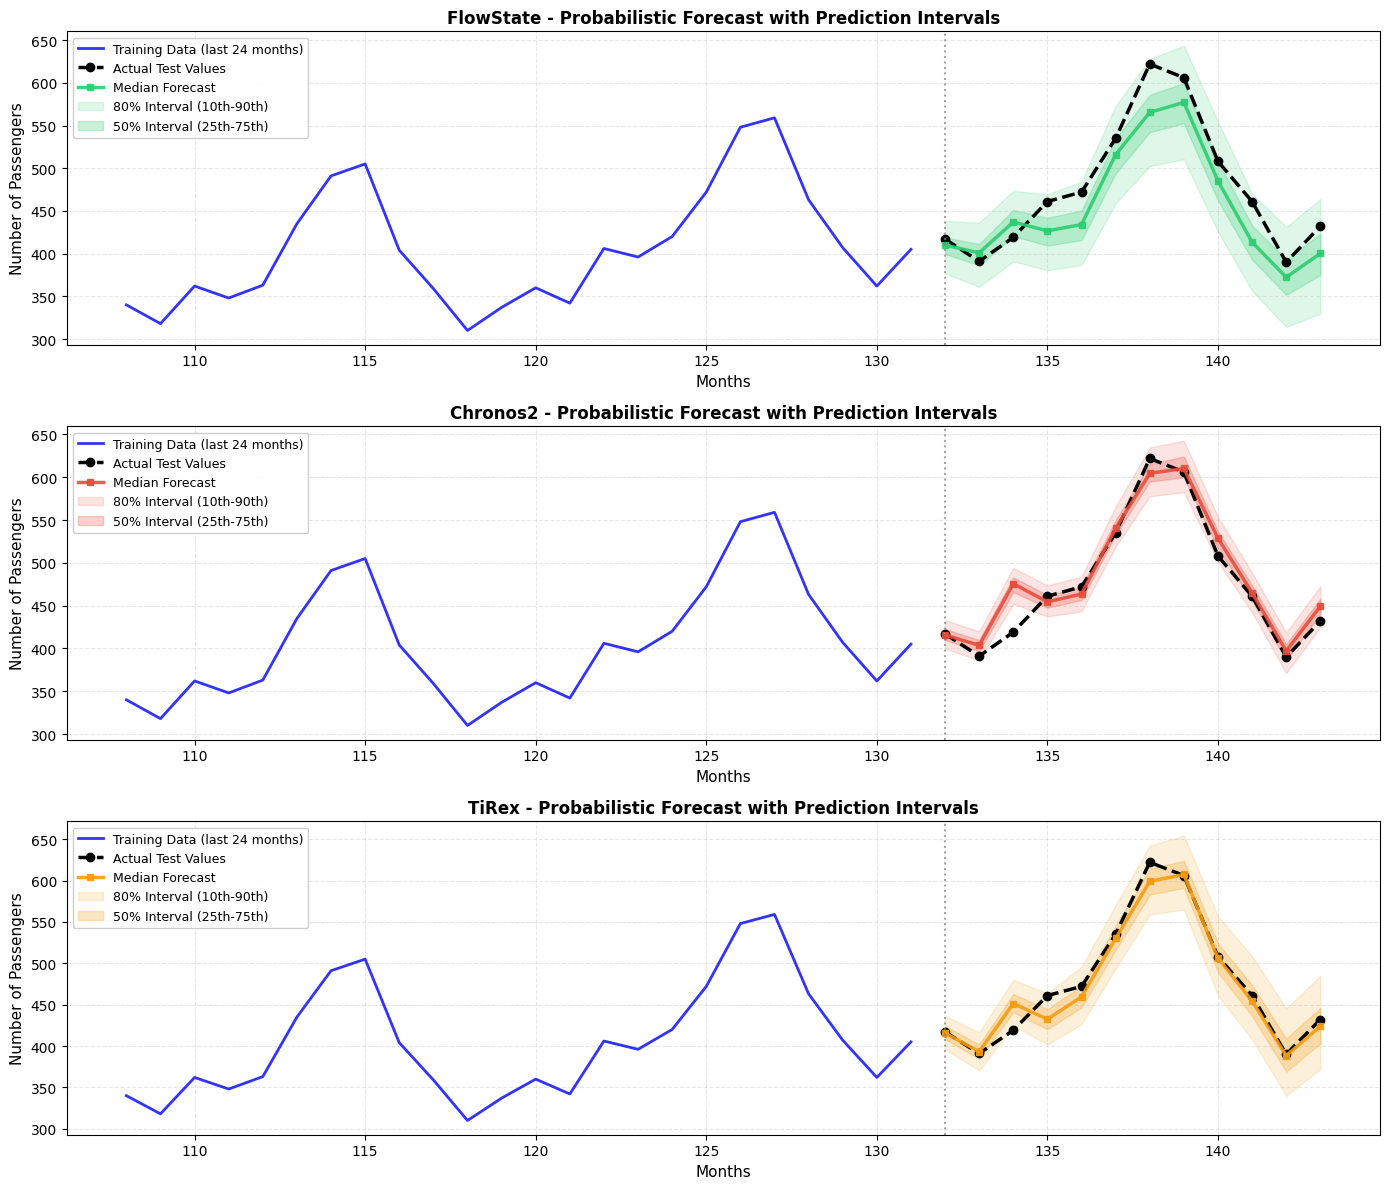

In [45]:
# Visualize quantile forecasts for all models
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Get actual training data length after truncation
actual_train_size = train_data_3d.shape[1]

# Show last 24 months of training data for context
train_context_start = max(0, actual_train_size - context_window)
train_context_indices = np.arange(train_context_start, actual_train_size)
test_indices = np.arange(actual_train_size, actual_train_size + horizon)

for idx, (model_name, quantiles) in enumerate(quantile_forecasts.items()):
    ax = axes[idx]
    
    # Plot training data (last 24 months for context)
    ax.plot(
        train_context_indices,
        train_data[train_context_start:],
        label="Training Data (last 24 months)",
        color="blue",
        linewidth=2,
        alpha=0.8
    )
    
    # Plot test data (actual values)
    ax.plot(
        test_indices,
        test_data,
        label="Actual Test Values",
        color="black",
        linewidth=2.5,
        linestyle="--",
        marker="o",
        markersize=6
    )
    
    # Extract quantiles: shape is (batch=1, horizon=12, quantiles=9, features=1)
    q_min = 0  # 10th percentile
    q_median = 4  # 50th percentile
    q_max = 8  # 90th percentile
    q_lower_25 = 2  # 25th percentile
    q_upper_75 = 6  # 75th percentile
    
    # Plot median forecast
    ax.plot(
        test_indices,
        quantiles[0, :, q_median, 0],
        label="Median Forecast",
        color=colors[model_name],
        linewidth=2.5,
        marker="s",
        markersize=5,
        alpha=0.9
    )
    
    # Plot 80% prediction interval (10th to 90th percentile)
    ax.fill_between(
        test_indices,
        quantiles[0, :, q_min, 0],
        quantiles[0, :, q_max, 0],
        alpha=0.15,
        color=colors[model_name],
        label="80% Interval (10th-90th)"
    )
    
    # Plot 50% prediction interval (25th to 75th percentile)
    ax.fill_between(
        test_indices,
        quantiles[0, :, q_lower_25, 0],
        quantiles[0, :, q_upper_75, 0],
        alpha=0.25,
        color=colors[model_name],
        label="50% Interval (25th-75th)"
    )
    
    # Add separator line
    ax.axvline(x=actual_train_size, color="gray", linestyle=":", linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel("Months", fontsize=11)
    ax.set_ylabel("Number of Passengers", fontsize=11)
    ax.set_title(f"{model_name} - Probabilistic Forecast with Prediction Intervals", fontsize=12, fontweight="bold")
    ax.legend(loc="best", fontsize=9, framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated end-to-end time-series forecasting using the FAIM platform on the classic AirPassengers dataset:

### Key Findings:
1. **Point Forecasts**: All three models (FlowState, Chronos2, TiRex) successfully generated 12-month ahead predictions. The evaluation metrics (MAE and MSE) show varying performance across models, allowing you to select the best model for your use case.

2. **Probabilistic Forecasts**: Each model provided quantile-based uncertainty estimates, enabling the computation of prediction intervals. These are crucial for planning and decision-making in real-world applications.

3. **Model Comparison**: 
   - The visualizations clearly show how each model captures the seasonal patterns and trend in airline passenger data
   - Some models may perform better on capturing peaks (summer travel) vs. troughs (winter travel)
   - The probabilistic forecasts reveal different calibration properties across models - some may be more conservative (wider intervals) while others are more confident

4. **Seasonal Patterns**: The AirPassengers dataset's clear seasonal patterns (summer peaks, winter troughs) provide a good benchmark for evaluating how well each foundation model captures temporal dependencies.

### Next Steps:
- Experiment with different forecast horizons (e.g., 6 months, 24 months)
- Try with different datasets or your own time-series data
- Use the evaluation metrics to select the best model for your application
- Explore the probabilistic forecasts for risk management and confidence intervals
- Compare performance on datasets with different characteristics (trend, seasonality, noise)

For more information, visit the [FAIM documentation](https://faim.it.com)